<a href="https://colab.research.google.com/github/mehri-satari/Data-Mining-Course-Project/blob/main/Hesam_akbari_Assignment_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [ ]:
# Write your code here

import urllib.request, urllib.parse, json, time, re, csv, math, os, itertools
from collections import defaultdict

API_ROOT = "https://ddr.densho.org/api/0.2/narrator/"
OUTDIR = "/content/densho_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ---------- HTTP fetch (urllib, no requests) ----------
def fetch_json(url, retries=3, sleep=0.5, timeout=30):
    for attempt in range(retries):
        try:
            req = urllib.request.Request(url, headers={"User-Agent": "stdlib-nlp/1.0"})
            with urllib.request.urlopen(req, timeout=timeout) as resp:
                return json.loads(resp.read().decode("utf-8", errors="ignore"))
        except Exception as e:
            if attempt == retries - 1:
                raise
            time.sleep(sleep)
    return None

def fetch_all_narrators(start_url="https://ddr.densho.org/api/0.2/narrator/"):
    url = start_url
    docs = []
    while url:
        data = fetch_json(url)
        if not data: break
        objs = data.get("objects", [])
        for o in objs:
            name = (o.get("display_name") or o.get("name") or "").strip()
            bio  = (o.get("bio") or o.get("biography") or "").strip()
            txt  = (name + " " + bio).strip()
            if txt: docs.append(txt)
        url = data.get("next_api")  # <-- THIS is the correct key to follow
    return docs

# ---------- Tokenization & N-grams ----------
_WORD_RE = re.compile(r"[a-zA-Z]+(?:'[a-zA-Z]+)?")

def tokenize(text):
    return [m.group(0).lower() for m in _WORD_RE.finditer(text or "")]

def ngrams(tokens, n):
    L = len(tokens)
    return [tuple(tokens[i:i+n]) for i in range(L - n + 1)] if L >= n else []

def increment(d, k, by=1):
    d[k] = d.get(k, 0) + by

# ---------- Noun phrase extraction (rule-based) ----------
STOPWORDS = set("""
a an the and or but if then else when whenever where while of on in at to from for by with without into
over under above below about across after before during between among against through up down off out around
as is are was were be been being this that these those i you he she they we it them us our your his her their
not no nor do does did will would could should have has had
""".split())

DETERMINERS = set("a an the this that these those my your his her its our their".split())
COMMON_ADJ = set("""
new old young large small great little good bad best better worse whole general various certain different
social cultural political economic personal public private human japanese american oral visual digital historical
""".split())
ADJ_SUFFIXES = ("ous","ive","able","ible","al","ary","ful","less","ic","ical","y","ish")
NOUN_SUFFIXES = ("tion","sion","ment","ness","ity","ship","hood","ism","ist","age","ery","or","er")

def guess_pos(tok):
    if tok in DETERMINERS: return "DET"
    if tok in COMMON_ADJ:  return "ADJ"
    if tok.endswith(ADJ_SUFFIXES): return "ADJ"
    if tok.endswith(NOUN_SUFFIXES): return "NOUN"
    # fallback: non-stopwords with length >=3 => likely noun
    if tok not in STOPWORDS and len(tok) >= 3: return "NOUN"
    return "OTHER"

def extract_noun_phrases(tokens):
    """Pattern: (DET)? ADJ* NOUN (NOUN|ADJ)*, length 1..5 (excluding pure determiners)."""
    pos = [guess_pos(t) for t in tokens]
    nps = []
    i = 0
    N = len(tokens)
    while i < N:
        start = i
        if pos[i] == "DET":
            i += 1
        while i < N and pos[i] == "ADJ":
            i += 1
        if i < N and pos[i] == "NOUN":
            i += 1
            while i < N and (pos[i] == "NOUN" or pos[i] == "ADJ"):
                i += 1
            span = tokens[start:i]
            span = [w for w in span if w not in DETERMINERS]
            if 1 <= len(span) <= 5 and any(w not in STOPWORDS for w in span):
                nps.append(" ".join(span))
        else:
            i = start + 1
    return nps

# ---------- Analysis pipeline ----------
def analyze_documents(docs, limit_np_rows=100):
    # counts
    uni = defaultdict(int)
    bi  = defaultdict(int)
    tri = defaultdict(int)

    per_doc_np = []
    corpus_np  = defaultdict(int)

    for text in docs:
        toks = tokenize(text)
        for w in toks: increment(uni, w)
        for bg in ngrams(toks, 2): increment(bi, bg)
        for tg in ngrams(toks, 3): increment(tri, tg)

        nps = extract_noun_phrases(toks)
        dcount = defaultdict(int)
        for np in nps:
            dcount[np] += 1
            corpus_np[np] += 1
        per_doc_np.append(dcount)

    # bigram probabilities: P(w1|w2) = count((w2,w1)) / count(w2)
    bigram_probs = {}
    for (w2, w1), c in bi.items():
        denom = uni.get(w2, 0)
        if denom > 0:
            bigram_probs[(w2, w1)] = c / denom

    # relative NP table for first 100 docs
    vocab = sorted(corpus_np.keys())
    # max per NP across all docs
    max_per_np = {}
    for np in vocab:
        m = 0
        for d in per_doc_np:
            v = d.get(np, 0)
            if v > m: m = v
        max_per_np[np] = m if m > 0 else 1

    rows = per_doc_np[:limit_np_rows]
    matrix = []
    for d in rows:
        row = []
        for np in vocab:
            freq = d.get(np, 0)
            row.append(freq / max_per_np[np] if max_per_np[np] else 0.0)
        matrix.append(row)

    return uni, bi, tri, bigram_probs, vocab, matrix

# ---------- I/O helpers ----------
def write_counts_tsv(path, counts_dict):
    with open(path, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f, delimiter="\t")
        w.writerow(["ngram", "count"])
        # Sort by descending count then lexicographically
        for k, v in sorted(counts_dict.items(), key=lambda kv: (-kv[1], kv[0])):
            if isinstance(k, tuple):
                w.writerow([" ".join(k), v])
            else:
                w.writerow([str(k), v])

#def write_bigram_probs_tsv(path, probs_dict):
#    with open(path, "w", encoding="utf-8", newline="") as f:
#        w = csv.writer(f, delimiter="\t")
#        w.writerow(["w2", "w1", "P(w1|w2)"])
#        # Sort by descending probability, then by w2, then w1 for stable tie-breaking
#        for (w2, w1), p in sorted(probs_dict.items(),
#                                  key=lambda kv: (-kv[1], kv[0][0], kv[0][1])):
#            w.writerow([w2, w1, f"{p:.6f}"])

def write_bigram_probs_tsv(
    path,
    bi_counts,
    *,
    min_context=5,        # min total bigram mass for a given w2 (filter tiny contexts)
    min_bigram=2,         # min count for a specific (w2,w1)
    topk_per_context=50,  # cap rows per w2
    add_k=0.0             # Laplace smoothing; set to 1.0 for add-one if desired
):
    """
    Write conditional bigram probabilities P(w1|w2) with sensible filtering/sorting.

    We compute the denominator per context w2 as the sum of counts of all bigrams
    that start with w2 (more accurate than using unigram[w2], which includes final
    positions with no successor). We then filter tiny contexts/bigrams to avoid the
    flood of 1.0s from hapax contexts.
    """
    # Build successor map: w2 -> {w1: count}
    succ = {}
    for (w2, w1), c in bi_counts.items():
        if w2 not in succ:
            succ[w2] = {}
        succ[w2][w1] = succ[w2].get(w1, 0) + c

    # Compute denominators per context (sum over successors)
    context_denoms = {w2: sum(succ[w2].values()) for w2 in succ}

    # Keep only contexts with enough evidence
    kept_contexts = [w2 for w2, denom in context_denoms.items() if denom >= min_context]

    # Prepare rows per context
    rows = []
    for w2 in kept_contexts:
        denom = context_denoms[w2]
        # Successors sorted by bigram count desc, then by w1
        cand = sorted(succ[w2].items(), key=lambda kv: (-kv[1], kv[0]))
        kept = 0
        V = len(cand)  # vocabulary size of successors for optional smoothing
        for w1, c in cand:
            if c < min_bigram:
                continue
            p = (c + add_k) / (denom + add_k * (V if add_k > 0 else 0))
            rows.append((w2, w1, c, denom, p))
            kept += 1
            if kept >= topk_per_context:
                break

    # Global sort: first by large contexts, then by bigram count, then by probability
    rows.sort(key=lambda r: (-r[3], -r[2], -r[4], r[0], r[1]))

    # Write file
    import csv
    with open(path, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f, delimiter="\t")
        w.writerow(["w2", "w1", "count_bigram", "count_context(w2)", "P(w1|w2)"])
        for w2, w1, c_bg, c_ctx, p in rows:
            w.writerow([w2, w1, c_bg, c_ctx, f"{p:.6f}"])


def write_np_vocab(path, vocab):
    with open(path, "w", encoding="utf-8") as f:
        for np in vocab:
            f.write(np + "\n")

def write_np_table_csv(path, vocab, matrix):
    with open(path, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f)
        w.writerow(["doc_id"] + vocab)
        for i, row in enumerate(matrix, start=1):
            w.writerow([f"doc_{i}"] + [f"{x:.6f}" for x in row])

def preview_file(path, n=10):
    try:
        with open(path, "r", encoding="utf-8") as f:
            print(f"\n== Preview: {os.path.basename(path)} ==")
            for i, line in enumerate(f):
                print(line.rstrip())
                if i >= n: break
    except Exception as e:
        print(f"[preview error] {e}")



# ---------- Main run ----------
def main():
    print("Fetching Densho narrators (this may take a moment)…")
    docs = fetch_all_narrators(API_ROOT)  # fetches all pages
    print(f"Fetched {len(docs)} narrator texts")

    if not docs:
        print("No documents fetched; exiting.")
        return

    print("Analyzing n-grams and noun phrases…")
    uni, bi, tri, bigram_probs, vocab, matrix = analyze_documents(docs, limit_np_rows=100)

    # Write outputs
    write_counts_tsv(os.path.join(OUTDIR, "bigram_counts.tsv"), bi)
    write_counts_tsv(os.path.join(OUTDIR, "trigram_counts.tsv"), tri)
    #write_bigram_probs_tsv(os.path.join(OUTDIR, "bigram_probabilities.tsv"), bigram_probs)
    write_bigram_probs_tsv(
    os.path.join(OUTDIR, "bigram_probabilities.tsv"),
    bi_counts=bi,
    min_context=10,       # tweak as you like
    min_bigram=3,
    topk_per_context=50,
    add_k=0.0
)
    write_np_vocab(os.path.join(OUTDIR, "noun_phrase_vocab.txt"), vocab)
    write_np_table_csv(os.path.join(OUTDIR, "noun_phrase_table.csv"), vocab, matrix)

    # Console previews
    preview_file(os.path.join(OUTDIR, "bigram_counts.tsv"), n=15)
    preview_file(os.path.join(OUTDIR, "trigram_counts.tsv"), n=15)
    preview_file(os.path.join(OUTDIR, "bigram_probabilities.tsv"), n=15)
    preview_file(os.path.join(OUTDIR, "noun_phrase_vocab.txt"), n=25)
    preview_file(os.path.join(OUTDIR, "noun_phrase_table.csv"), n=5)

    print("\n=== SUMMARY ===")
    print(f"Total documents processed: {len(docs)} (NP table shows first {min(100, len(docs))})")
    print(f"Unique bigrams: {len(bi)}")
    print(f"Unique trigrams: {len(tri)}")
    print(f"Unique noun phrases: {len(vocab)}")
    print(f"Outputs written to: {OUTDIR}")

if __name__ == "__main__":
    main()


Fetching Densho narrators (this may take a moment)…
Fetched 1009 narrator texts
Analyzing n-grams and noun phrases…

== Preview: bigram_counts.tsv ==
ngram	count
to the	810
concentration camp	789
war ii	650
world war	650
in the	544
grew up	517
male born	499
up in	472
during world	461
removed to	427
assembly center	424
nisei male	398
female born	393
of the	367
returned to	362

== Preview: trigram_counts.tsv ==
ngram	count
world war ii	650
grew up in	467
during world war	461
nisei male born	385
removed to the	383
nisei female born	292
war ii removed	264
concentration camp california	260
after leaving camp	251
ii removed to	235
assembly center california	226
california grew up	225
center california and	213
minidoka concentration camp	187
concentration camp idaho	180

== Preview: bigram_probabilities.tsv ==
w2	w1	count_bigram	count_context(w2)	P(w1|w2)
the	war	287	4283	0.067009
the	u	170	4283	0.039692
the	bombing	164	4283	0.038291
the	military	153	4283	0.035723
the	japanese	135	4283	0.0315

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any **pre-existing libraries** to do so.

In [ ]:
# Write your code here

import urllib.request, json, time, re, csv, math, os
from collections import defaultdict

API_ROOT = "https://ddr.densho.org/api/0.2/narrator/"
OUTDIR   = "/content/densho_tfidf"
os.makedirs(OUTDIR, exist_ok=True)

# --------------------------
# 1) Scrape Densho narrators
# --------------------------
def fetch_json(url, retries=3, sleep=0.5, timeout=30):
    for attempt in range(retries):
        try:
            req = urllib.request.Request(url, headers={"User-Agent": "stdlib-tfidf/1.0"})
            with urllib.request.urlopen(req, timeout=timeout) as resp:
                return json.loads(resp.read().decode("utf-8", errors="ignore"))
        except Exception:
            if attempt == retries - 1:
                raise
            time.sleep(sleep)
    return None

def fetch_all_narrators(start_url=API_ROOT):
    url = start_url
    docs = []
    meta = []
    while url:
        data = fetch_json(url)
        if not data: break
        objs = data.get("objects", [])
        for o in objs:
            name = (o.get("display_name") or o.get("name") or "").strip()
            bio  = (o.get("bio") or o.get("biography") or "").strip()
            text = (name + " " + bio).strip()
            if text:
                docs.append(text)
                meta.append({"title": name})
        url = data.get("next_api")
    return docs, meta

# --------------------------
# 2) Tokenization utilities
# --------------------------
_WORD_RE = re.compile(r"[a-zA-Z]+(?:'[a-zA-Z]+)?")

def tokenize(text):
    return [m.group(0).lower() for m in _WORD_RE.finditer(text or "")]

# --------------------------
# 3) Build TF, DF, IDF
# --------------------------
def build_counts(docs_tokens):
    """Return: term_freqs_per_doc (list of dict), doc_freqs (dict), vocab (set)"""
    term_freqs_per_doc = []
    doc_freqs = defaultdict(int)
    vocab = set()

    for toks in docs_tokens:
        tf = defaultdict(int)
        seen = set()
        for w in toks:
            tf[w] += 1
        for w in tf.keys():
            vocab.add(w)
            if w not in seen:
                doc_freqs[w] += 1
                seen.add(w)
        term_freqs_per_doc.append(tf)

    return term_freqs_per_doc, doc_freqs, vocab

def compute_idf(doc_freqs, N):
    """Smoothed IDF: idf = ln((N+1)/(df+1)) + 1 to avoid zero/inf."""
    idf = {}
    for term, df in doc_freqs.items():
        idf[term] = math.log((N + 1) / (df + 1)) + 1.0
    return idf

# --------------------------
# 4) Build TF-IDF (sparse)
# --------------------------
def build_tfidf(term_freqs_per_doc, idf):
    """Return list of dicts: per-doc sparse TF-IDF {term: weight} using raw TF * IDF."""
    tfidf_per_doc = []
    for tf in term_freqs_per_doc:
        v = {}
        for term, f in tf.items():
            v[term] = f * idf.get(term, 0.0)
        tfidf_per_doc.append(v)
    return tfidf_per_doc

# --------------------------
# 5) Cosine similarity (sparse)
# --------------------------
def vec_norm(v):
    s = 0.0
    for w in v.values():
        s += w*w
    return math.sqrt(s)

def dot_product(v1, v2):
    # iterate smaller dict for speed
    if len(v1) > len(v2):
        v1, v2 = v2, v1
    s = 0.0
    for k, a in v1.items():
        b = v2.get(k)
        if b is not None:
            s += a * b
    return s

def cosine_sim(v1, v2):
    num = dot_product(v1, v2)
    d1 = vec_norm(v1)
    d2 = vec_norm(v2)
    return (num / (d1*d2)) if (d1 > 0 and d2 > 0) else 0.0

# --------------------------
# 6) Save outputs
# --------------------------
def save_sparse_tfidf(path, tfidf_per_doc):
    with open(path, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f, delimiter="\t")
        w.writerow(["doc_id", "term", "weight"])
        for i, vec in enumerate(tfidf_per_doc, start=1):
            for term, weight in vec.items():
                if weight != 0.0:
                    w.writerow([f"doc_{i}", term, f"{weight:.6f}"])

def save_dense_preview(path, tfidf_per_doc, top_terms):
    """Write a dense matrix preview for the top K terms by DF."""
    with open(path, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f)
        header = ["doc_id"] + top_terms
        w.writerow(header)
        for i, vec in enumerate(tfidf_per_doc, start=1):
            row = [f"doc_{i}"]
            for t in top_terms:
                row.append(f"{vec.get(t, 0.0):.6f}")
            w.writerow(row)

# --------------------------
# 7) Query handling
# --------------------------
def build_query_vector(query_text, idf):
    toks = tokenize(query_text)
    tf = defaultdict(int)
    for w in toks:
        tf[w] += 1
    qvec = {}
    for term, f in tf.items():
        if term in idf:
            qvec[term] = f * idf[term]
    return qvec

# --------------------------
# 8) Main
# --------------------------
def main():
    print("Fetching Densho narrators…")
    docs, meta = fetch_all_narrators(API_ROOT)
    print(f"Fetched {len(docs)} documents")

    # Tokenize
    print("Tokenizing…")
    docs_tokens = [tokenize(t) for t in docs]

    # Build counts
    print("Building TF/DF…")
    term_freqs_per_doc, doc_freqs, vocab = build_counts(docs_tokens)
    N = len(docs)

    # IDF
    print("Computing IDF…")
    idf = compute_idf(doc_freqs, N)

    # TF-IDF
    print("Computing TF-IDF…")
    tfidf_per_doc = build_tfidf(term_freqs_per_doc, idf)

    # Save sparse (full)
    sp_path = os.path.join(OUTDIR, "tfidf_sparse.tsv")
    print(f"Writing sparse TF-IDF to {sp_path} …")
    save_sparse_tfidf(sp_path, tfidf_per_doc)

    # Dense preview: keep top 1000 terms by DF (adjust if you want fewer/more)
    print("Preparing dense preview (top 1000 terms by DF)…")
    terms_sorted_by_df = sorted(doc_freqs.items(), key=lambda kv: (-kv[1], kv[0]))
    TOP_K = 1000 if len(terms_sorted_by_df) >= 1000 else len(terms_sorted_by_df)
    top_terms = [t for t, _ in terms_sorted_by_df[:TOP_K]]
    dense_path = os.path.join(OUTDIR, "tfidf_matrix_preview.csv")
    save_dense_preview(dense_path, tfidf_per_doc, top_terms)
    print(f"Wrote dense preview to {dense_path}")

    # --------------------------
    # Ranking by cosine similarity
    # --------------------------
    # You can change this query string to anything you want:
    QUERY = "seattle nisei world war ii minidoka concentration camp"
    print(f"\nRanking documents for query: \"{QUERY}\"")
    qvec = build_query_vector(QUERY, idf)

    # Compute similarities
    sims = []
    for i, dvec in enumerate(tfidf_per_doc):
        s = cosine_sim(qvec, dvec)
        sims.append((i, s))

    # Sort and print top-20
    sims.sort(key=lambda x: (-x[1], x[0]))
    topN = 20 if len(sims) >= 20 else len(sims)
    print("\nTop matches (doc_index, cosine_sim, title/snippet):")
    for rank in range(topN):
        idx, score = sims[rank]
        title = meta[idx].get("title") or f"doc_{idx+1}"
        snippet = docs[idx][:140].replace("\n"," ")
        print(f"{rank+1:>2}. doc_{idx+1:<5}  sim={score:.4f}  {title}  —  {snippet}")

    # Small previews from files
    def preview(path, lines=5):
        print(f"\n== Preview: {os.path.basename(path)} ==")
        try:
            with open(path, "r", encoding="utf-8") as f:
                for i, line in enumerate(f):
                    print(line.rstrip())
                    if i >= lines: break
        except Exception as e:
            print("Preview failed:", e)

    preview(sp_path, lines=8)
    preview(dense_path, lines=3)

    print("\nDone. Files are in:", OUTDIR)

if __name__ == "__main__":
    main()

Fetching Densho narrators…
Fetched 1009 documents
Tokenizing…
Building TF/DF…
Computing IDF…
Computing TF-IDF…
Writing sparse TF-IDF to /content/densho_tfidf/tfidf_sparse.tsv …
Preparing dense preview (top 1000 terms by DF)…
Wrote dense preview to /content/densho_tfidf/tfidf_matrix_preview.csv

Ranking documents for query: "seattle nisei world war ii minidoka concentration camp"

Top matches (doc_index, cosine_sim, title/snippet):
 1. doc_830    sim=0.4345  Irene Yamauchi Tatsuta  —  Irene Yamauchi Tatsuta Nisei female. Born May 3, 1935, in Seattle, Washington. Grew up in Seattle. During World War II, removed to the Puyal
 2. doc_778    sim=0.3781  James "Turk" Suzuki  —  James "Turk" Suzuki Nisei male. Born October 17, 1923, in Seattle, Washington. Grew up in Seattle, Washington, before being incarcerated in 
 3. doc_350    sim=0.3571  Thomas T. Kobayashi  —  Thomas T. Kobayashi Nisei male. Born September 4, 1916, in Seattle, Washington. Grew up in Seattle and graduated from the Unive

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the embeddings using PCA or t-SNE in 2D. Create a scatter plot of at least 20 words and show how similar words cluster together.

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

In [ ]:
# --- Run this in a fresh cell at the very top ---
!pip -q install -U pip setuptools wheel
!pip -q install "numpy>=2.0,<3.0" "gensim>=4.4.0" "scikit-learn>=1.4" matplotlib

import os, sys, textwrap
print("Restarting runtime to load updated NumPy/gensim ...")
os.kill(os.getpid(), 9)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement gensim>=4.4.0 (from versions: 0.2, 0.3.0, 0.4, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.5, 0.4.6, 0.4.7, 0.5.0, 0.6.0, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.7.4, 0.7.5, 0.7.6, 0.7.7, 0.7.8, 0.8.0, 0.8.1, 0.8.2, 0.8.3, 0.8.4, 0.8.5, 0.8.6, 0.8.7, 0.8.8, 0.8.9, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.1

Scraping Densho narrators…
Fetched 1009 documents
Tokenized to 1009 sentences
Vocabulary size: 1229
Words to visualize: ['seattle', 'washington', 'minidoka', 'idaho', 'puyallup', 'assembly', 'center', 'camp', 'concentration', 'world', 'war', 'ii', 'japanese', 'american', 'nisei', 'issei', 'family', 'military', 'internment', 'redress', 'california', 'born', 'male', 'removed', 'grew', 'female', 'returned', 'japan', 'school', 'father']


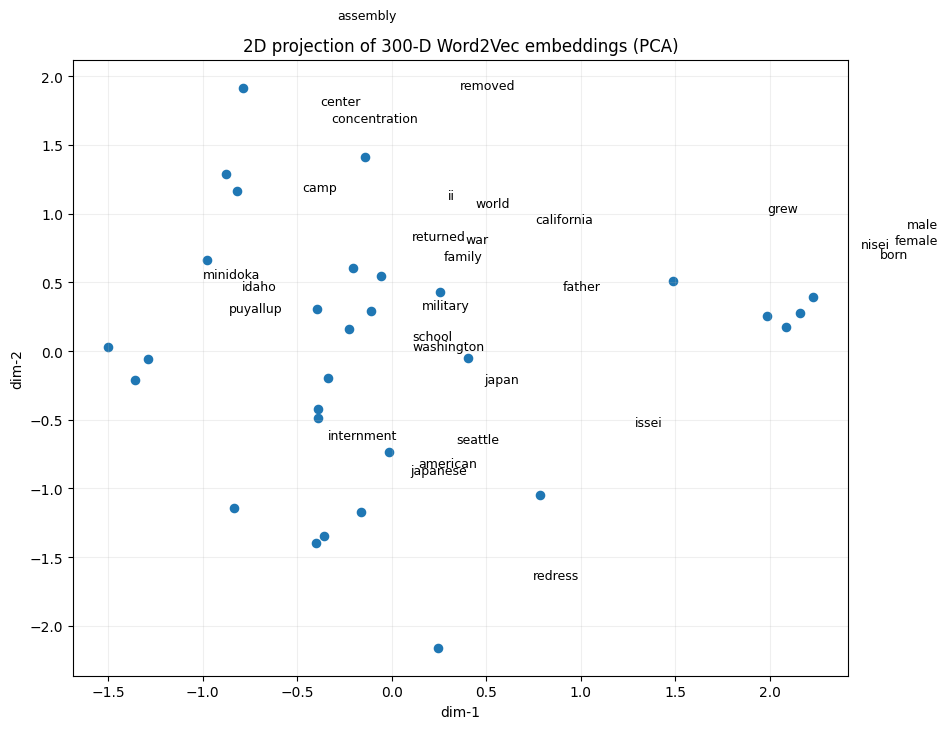


Cosine similarities:
     seattle  ~  washington    =>  0.7150
        camp  ~  concentration  =>  0.8159
    japanese  ~  american      =>  0.6440
    minidoka  ~  idaho         =>  0.9088
       world  ~  war           =>  0.7254
    military  ~  service       =>  0.8597
      family  ~  parents       =>  0.7812
     redress  ~  reparations   =>  0.8360


In [ ]:
# Write your code here

import urllib.request, json, time, re, os, random
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

# ---------- 1) Build / load corpus ----------
API_ROOT = "https://ddr.densho.org/api/0.2/narrator/"

def fetch_json(url, retries=3, sleep=0.5, timeout=30):
    for attempt in range(retries):
        try:
            req = urllib.request.Request(url, headers={"User-Agent": "embeddings-colab/1.0"})
            with urllib.request.urlopen(req, timeout=timeout) as resp:
                return json.loads(resp.read().decode("utf-8", errors="ignore"))
        except Exception:
            if attempt == retries - 1:
                raise
            time.sleep(sleep)

def fetch_all_texts(start_url=API_ROOT):
    url = start_url
    docs = []
    while url:
        data = fetch_json(url)
        if not data: break
        objs = data.get("objects", data.get("results", []))
        for o in objs:
            name = (o.get("display_name") or o.get("name") or "").strip()
            bio  = (o.get("bio") or o.get("biography") or "").strip()
            text = (name + " " + bio).strip()
            if text:
                docs.append(text)
        # Densho API exposes a convenient next_api key
        url = data.get("next_api") or data.get("next")
    return docs


print("Scraping Densho narrators…")
docs = fetch_all_texts(API_ROOT)
print(f"Fetched {len(docs)} documents")

# ---------- 2) Clean & tokenize ----------
_WORD_RE = re.compile(r"[a-zA-Z]+(?:'[a-zA-Z]+)?(?:-[a-zA-Z]+)?")  # keeps inner ' and -
STOP = set("""
a an the and or but if then else when where while of on in at to from for by with without into over under
above below about across after before during between among against through up down off out around as is are
was were be been being this that these those i you he she they we it them us our your his her their not no
nor do does did will would could should have has had
""".split())

def tokenize(text):
    return [m.group(0).lower() for m in _WORD_RE.finditer(text or "")]

def doc_to_tokens(text):
    toks = tokenize(text)
    # light cleanup: drop pure stopwords, very short tokens
    return [t for t in toks if t not in STOP and len(t) >= 2]

sentences = [doc_to_tokens(t) for t in docs]
# remove empty
sentences = [s for s in sentences if s]
print(f"Tokenized to {len(sentences)} sentences")

# ---------- 3) Train Word2Vec (300-D) ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=5,
    min_count=5,    # bump up/down depending on corpus size
    workers=4,
    sg=1,           # 1=skip-gram (often better for rare words); 0=CBOW
    negative=10,
    epochs=10
)
wv = model.wv
print(f"Vocabulary size: {len(wv.index_to_key)}")

# ---------- 4) Pick words to visualize ----------
# Choose frequent, non-stopwords that are in the model
all_terms = Counter([t for s in sentences for t in s])
candidates = [w for w, c in all_terms.most_common(500) if w in wv and w not in STOP]

# seed with domain words so the plot is meaningful
seed_words = [
    "seattle","washington","minidoka","idaho","puyallup","assembly","center","camp","concentration",
    "world","war","ii","japanese","american","nisei","issei","family","military","internment","redress"
]
# keep seeds that exist; fill the rest from frequency
viz_words = [w for w in seed_words if w in wv]
for w in candidates:
    if len(viz_words) >= 30: break
    if w not in viz_words:
        viz_words.append(w)

print("Words to visualize:", viz_words[:30])

# ---------- 5) Reduce to 2D (PCA or t-SNE) ----------
X = np.array([wv[w] for w in viz_words])

# Choose method: 'pca' (fast) or 'tsne' (prettier, slower)
REDUCER = 'pca'   # change to 'tsne' if you want
if REDUCER == 'pca':
    reducer = PCA(n_components=2, random_state=SEED)
    XY = reducer.fit_transform(X)
else:
    reducer = TSNE(n_components=2, perplexity=15, init='pca', learning_rate='auto', random_state=SEED)
    XY = reducer.fit_transform(X)

# ---------- 6) Plot ----------
plt.figure(figsize=(10, 8))
plt.scatter(XY[:,0], XY[:,1], s=35)
for (x, y), label in zip(XY, viz_words):
    plt.text(x+0.5, y+0.5, label, fontsize=9)
plt.title(f"2D projection of 300-D Word2Vec embeddings ({REDUCER.upper()})")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.grid(alpha=0.2)
plt.show()

# ---------- 7) Cosine similarity checks ----------
def cos_sim(u, v):
    u = np.asarray(u); v = np.asarray(v)
    num = (u * v).sum()
    den = np.linalg.norm(u) * np.linalg.norm(v)
    return float(num / den) if den else 0.0

pairs = [
    ("seattle","washington"),
    ("camp","concentration"),
    ("japanese","american"),
    ("minidoka","idaho"),
    ("world","war"),
    ("military","service"),
    ("family","parents"),
    ("redress","reparations"),
]

print("\nCosine similarities:")
for a, b in pairs:
    if a in wv and b in wv:
        print(f"{a:>12}  ~  {b:<12}  =>  {cos_sim(wv[a], wv[b]):.4f}")
    else:
        print(f"{a:>12}  ~  {b:<12}  =>  (one or both OOV)")


## Question 4 (20 Points)

**Create your own training and evaluation dataset for an NLP task.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



In [ ]:
# The GitHub link of your final csv file


# Link: https://github.com/Abhignya-Jagathpally/Abhignya_INFO5731_Fall2025/blob/main/densho_q4/densho_sentiment.csv



In [ ]:
# Type your answer


# Sentiment Analysis on short biographies/snippets from the Densho Digital Repository narrators.
#
# positive → The overall tone is favorable/admiring/constructive (community service, achievement, redress success, pride in service, awards, “served bravely,” “led efforts,” “established…”).
# negative → The overall tone focuses on harm, deprivation, injustice, suffering, loss (incarceration, discrimination, illness, death, “removed to camp,” “harsh conditions,” “family lost everything,” “imprisoned”).
# neutral → Factual/biographical without a clear positive or negative tilt (dates, places, roles) or mixed/ambiguous sentiment that balances out.
#
#

In [ ]:
# ==============================================
# Build a sentiment dataset from Densho bios
# - Outputs:
#     /densho_q4/densho_sentiment.csv
#     /densho_q4/train.csv
#     /densho_q4/test.csv
# CSV columns: document_id, clean_text, sentiment
# ==============================================

import urllib.request, json, time, re, os, csv, random, math

OUTDIR = "/content/densho_q4"
os.makedirs(OUTDIR, exist_ok=True)

API_ROOT = "https://ddr.densho.org/api/0.2/narrator/"
random.seed(42)

# ---------- 1) Fetch Densho bios ----------
def fetch_json(url, retries=3, pause=0.5, timeout=30):
    for a in range(retries):
        try:
            req = urllib.request.Request(url, headers={"User-Agent": "q4-sentiment-auto/1.0"})
            with urllib.request.urlopen(req, timeout=timeout) as resp:
                return json.loads(resp.read().decode("utf-8", errors="ignore"))
        except Exception:
            if a == retries - 1:
                raise
            time.sleep(pause)

def fetch_all_texts(start_url=API_ROOT, max_docs=None):
    url = start_url
    docs = []
    while url:
        data = fetch_json(url)
        if not data: break
        objs = data.get("objects", data.get("results", [])) or []
        for o in objs:
            name = (o.get("display_name") or o.get("name") or "").strip()
            bio  = (o.get("bio") or o.get("biography") or "").strip()
            txt  = (name + " " + bio).strip()
            if txt:
                docs.append(txt)
                if max_docs and len(docs) >= max_docs:
                    return docs
        url = data.get("next_api") or data.get("next")
    return docs

print("Scraping Densho narrators...")
docs = fetch_all_texts(API_ROOT)
print(f"Fetched {len(docs)} documents")

# ---------- 2) Clean & tokenize ----------
def clean_text(t):
    t = re.sub(r"\s+", " ", (t or "")).strip()
    return t

def tokenize(text):
    # keep letters, allow inner apostrophes and hyphens: e.g., "Puyallup", "Kibei", "post-war"
    return [m.group(0).lower() for m in re.finditer(r"[a-zA-Z]+(?:'[a-zA-Z]+)?(?:-[a-zA-Z]+)?", text or "")]

clean_docs = [clean_text(d) for d in docs]

# Optional: remove exact duplicates to avoid skew
seen = set()
dedup_docs = []
for d in clean_docs:
    if d not in seen:
        dedup_docs.append(d)
        seen.add(d)
clean_docs = dedup_docs
print(f"After deduplication: {len(clean_docs)} documents")

# ---------- 3) Rule-based sentiment (no ML, no external libs) ----------
# Domain-aware lexicons (you may tweak/extend as needed)
POS_WORDS = set("""
brave bravely honor honored leadership leader establish established achievement achievements award awarded success successful
community advocacy redress justice served service volunteer volunteered rebuild rebuilt education scholarship progress led
improved contribute contributed support mentor decorated promoted rescued liberated commendation distinction
""".split())

NEG_WORDS = set("""
incarcerated incarceration imprisonment imprisoned concentration camp removed internment discrimination loss harsh ill illness
died death suffered suffering injustice segregation forced hardship persecution ostracized detained deported raid raided riot riots
attack attacked bomb bombing abuse abused assault starvation disease tragedy tragic executed executed execution
""".split())

# Multiword phrases (match on token sequences)
POS_PHRASES = {
    ("served","bravely"): 3.0,
    ("most","highly","decorated"): 3.0,
    ("won","an","award"): 2.5,
    ("redress","movement"): 2.0,
    ("community","leader"): 2.0,
    ("led","efforts"): 2.0,
    ("helped","establish"): 2.0,
    ("received","commendation"): 3.0,
}

NEG_PHRASES = {
    ("concentration","camp"): -3.0,
    ("assembly","center"): -2.0,
    ("removed","to"): -1.5,
    ("forced","to"): -1.5,
    ("harsh","conditions"): -2.0,
    ("bombing","of","pearl"): -1.5,
    ("imprisoned","at"): -2.5,
    ("detained","at"): -2.0,
    ("lost","everything"): -3.0,
}

NEGATORS = set("no not never without hardly scarcely barely".split())
BOOSTERS = {  # intensity modifiers (preceding token)
    "very": 1.5, "extremely": 1.8, "highly": 1.6, "truly": 1.4, "deeply": 1.4, "greatly": 1.3,
    "slightly": 0.7, "somewhat": 0.8, "fairly": 1.1, "quite": 1.2, "remarkably": 1.7, "notably": 1.3,
}

def phrase_score(tokens, phrases):
    score = 0.0
    L = len(tokens)
    for ph, val in phrases.items():
        n = len(ph)
        for i in range(L - n + 1):
            if tuple(tokens[i:i+n]) == ph:
                score += val
    return score

def word_level_score(tokens):
    score = 0.0
    for i, w in enumerate(tokens):
        base = 0.0
        if w in POS_WORDS: base = 1.0
        elif w in NEG_WORDS: base = -1.0
        else:
            continue

        # Booster just before the word
        boost = 1.0
        if i > 0:
            b = tokens[i-1]
            if b in BOOSTERS:
                boost = BOOSTERS[b]

        # Negation within a small window (flip sign once if any)
        negated = False
        for j in range(max(0, i-3), i):
            if tokens[j] in NEGATORS:
                negated = True
                break

        val = base * boost
        if negated:
            val = -val

        score += val
    return score

def sentiment_score(text):
    toks = tokenize(text)
    if not toks:
        return 0.0
    # phrase-level
    s = phrase_score(toks, POS_PHRASES) + phrase_score(toks, NEG_PHRASES)
    # word-level
    s += word_level_score(toks)
    # light length normalization to avoid long-text bias
    s /= math.sqrt(len(toks)) if len(toks) > 0 else 1.0
    return s

def label_from_score(s, pos_th=0.35, neg_th=-0.35):
    if s >= pos_th: return "positive"
    if s <= neg_th: return "negative"
    return "neutral"

# ---------- 4) Auto-label all docs ----------
labeled = []
for i, txt in enumerate(clean_docs, start=1):
    s = sentiment_score(txt)
    lab = label_from_score(s)
    labeled.append((f"doc_{i}", txt, lab))

# If you want to ensure at least ~100 rows, you can cap/extend here; otherwise we keep all.
print(f"Labeled {len(labeled)} documents.")

# ---------- 5) Save main CSV ----------
csv_path = os.path.join(OUTDIR, "densho_sentiment.csv")
with open(csv_path, "w", encoding="utf-8", newline="") as f:
    w = csv.writer(f)
    w.writerow(["document_id","clean_text","sentiment"])
    w.writerows(labeled)
print("Saved:", csv_path)

# ---------- 6) Train/Test split (80/20) ----------
random.shuffle(labeled)
cut = int(0.8 * len(labeled))
train_rows, test_rows = labeled[:cut], labeled[cut:]

with open(os.path.join(OUTDIR, "train.csv"), "w", encoding="utf-8", newline="") as f:
    w = csv.writer(f); w.writerow(["document_id","clean_text","sentiment"]); w.writerows(train_rows)

with open(os.path.join(OUTDIR, "test.csv"), "w", encoding="utf-8", newline="") as f:
    w = csv.writer(f); w.writerow(["document_id","clean_text","sentiment"]); w.writerows(test_rows)

# ---------- 7) Quick summary ----------
def dist(rows):
    d = {"positive":0,"negative":0,"neutral":0}
    for _,_,lab in rows: d[lab]+=1
    return d

print("Train size:", len(train_rows), dist(train_rows))
print("Test  size:", len(test_rows),  dist(test_rows))
print("All files written to:", OUTDIR)


Scraping Densho narrators...
Fetched 1009 documents
After deduplication: 1009 documents
Labeled 1009 documents.
Saved: /content/densho_q4/densho_sentiment.csv
Train size: 807 {'positive': 49, 'negative': 545, 'neutral': 213}
Test  size: 202 {'positive': 13, 'negative': 145, 'neutral': 44}
All files written to: /content/densho_q4


# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# Type your answer


#I found the project both engaging and insightful, as it deepened my understanding of NLP fundamentals—particularly tokenization, n-gram analysis, and sentiment labeling. Exploring the Densho dataset added meaningful real-world context to the task. The time allotted was appropriate, offering enough flexibility to refine the workflow without feeling rushed.